# Importing libraries

In [1]:
import pandas as pd
import numpy as np

from math import ceil, floor

pd.set_option('display.max_columns', None)

# Setup experiment parameters

In [2]:
# Used all orders to train
use_all_orders = True

# Reading input data

In [3]:
# Reading input sheets as dataframes
items_df = pd.read_csv('data/2024/items.csv', sep=';')
orders_df = pd.read_csv('data/2024/orders.csv', sep=';')
output_df = pd.read_csv('data/2024/orders_output.csv', sep=';')
pallets_df = pd.read_excel('data/pallet_types.xlsx')
current_sizes_arr = pd.read_excel('data/2024/currently_produced_sizes.xlsx')['currently_produced_sizes'].unique()

C:\Users\adondi\AppData\Local\Temp\ipykernel_14940\3939110622.py:4: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  output_df = pd.read_csv('data/2024/orders_output.csv', sep=';')


# Processing input data

In [4]:
# Get all item sizes
item_sizes = [sz.replace(',', '.') for sz in items_df['defom'].unique()]

# Get all item sizes currently produced
current_sizes = [sz for sz in item_sizes if sz in current_sizes_arr]

# Get all item sizes not being produced
not_produced_sizes = [sz for sz in item_sizes if sz not in current_sizes_arr]

# Get all item thicknesses
item_thickness = items_df['z_mm'].unique()

# Get production pallet types
prod_pallet_types = items_df['cdsup'].unique()

# Get maximum pallet weight and volume
pallets_df['volume'] = pallets_df['x_mm'] * pallets_df['y_mm'] * pallets_df['max_height']
shipping_pallets = pallets_df[pallets_df['used_for_shipping'] == 1]

max_pallet_weight = shipping_pallets['max_weight'].max()
max_pallet_volume = shipping_pallets['volume'].max()

In [5]:
# Function used to extract features of an item
def get_item_attr(row):
    
    # Dictionary with the attributes of the item
    attr = {
        'item': row['item_id'],
        'size': row['defom'].replace(',', '.'),
        'thickness': row['z_mm'],
        'special': row['exsz'],
        'weight': row['kgxsc'] / row['pzxsc'],
        'volume': row['x_mm'] * row['y_mm'] * row['z_mm'],
        'pieces_x_box': row['pzxsc'],
        'boxes_x_bundle': row['scxfrd'],
        'bundles_x_fullpallet': row['frdxplt'],
        'pieces_x_fullpallet': row['pzxsc'] * row['scxpl'],
        'pallet': row['cdsup']
    }

    return attr


# Extracting the attributes of each item
items_attr = pd.DataFrame(
    items_df.apply(
        lambda row : get_item_attr(row), 
        axis=1
).tolist())

# Remove duplicates from dataset
items_attr = items_attr.drop_duplicates(subset='item', keep='first')

# Set item ID as dataframe index
items_attr.set_index('item', inplace=True)
items_attr

,size,thickness,special,weight,volume,pieces_x_box,boxes_x_bundle,bundles_x_fullpallet,pieces_x_fullpallet,pallet
item,,,,,,,,,,
23240f8293 N 048,30X30,8.6,0.0,1.675000,774000.0,12.0,0.0,inf,576.0,9
23240f8293 S 048,30X30,8.6,0.0,1.675000,774000.0,12.0,2.0,24.0,576.0,F
a9245b804a E 048,30X30,8.6,0.0,1.675000,774000.0,12.0,0.0,inf,576.0,9
a9245b804a S 048,30X30,8.6,0.0,1.675000,774000.0,12.0,2.0,24.0,576.0,F
5274764a88 E 048,30X30,8.6,0.0,1.675000,774000.0,12.0,0.0,inf,576.0,9
...,...,...,...,...,...,...,...,...,...,...
760d5474d2 S 048,80X80,9.0,1.0,13.300000,5760000.0,2.0,8.0,6.0,96.0,X
634b27b9b9 S 040,60X60,9.0,0.0,7.076667,3240000.0,3.0,4.0,10.0,120.0,F
7a5007badc S 040,30X30,9.0,0.0,1.780000,810000.0,11.0,0.0,inf,440.0,9


In [6]:
# Function used to extract features from an item in an order
def get_order_item_attr(row, items_attr, item_sizes, item_thickness, prod_pallet_types):

    # Dictionary with the attributes of the order item
    attr = { 'errors': 0 }

    # Order number
    attr['order'] = row['order_number']

    # Homogeneous and fullorder data
    attr['homogeneous_order'] = row['homogeneous_order']
    attr['full_order'] = row['full_order']
    
    # Add flag to filter if item does not exists
    if row['item_id'] not in items_attr.index:
        attr['errors'] = 1
        return attr
    
    # Get corresponding item data
    item = items_attr.loc[row['item_id']]

    # Quantity of the item in the order
    pieces = row['pieces']

    # One-hot encoding for size types
    for size in item_sizes:

        quant = (pieces if size == item['size'] else 0)
        
        attr[size] = quant
        # attr[size + '_weight'] = quant * item['weight']
        # attr[size + '_volume'] = quant * item['volume']
        # attr[size + '_special'] = quant * item['special']

    # Total pieces
    attr['pieces'] = pieces

    # Total weight
    attr['weight'] = pieces * item['weight']

    # Total volume
    attr['volume'] = pieces * item['volume']

    # Upper bound
    attr['HS'] = pieces / item['pieces_x_fullpallet']

    return attr

# Extracting the attributes of each item of the order (removing invalid orders)
order_items_attr = pd.DataFrame(
    orders_df.dropna().apply(
        lambda row : get_order_item_attr(row, items_attr, item_sizes, item_thickness, prod_pallet_types), 
        axis=1
).tolist())

order_items_attr

,errors,order,homogeneous_order,full_order,30X30,20X20,30X60,60X60,22.5X90,60X120,45X90,75X75,30.5X56,30.5X91.5,60X60 SP,40X80,30X60 SP,45X90 SP,75X150,25X150,30X120 SP,120X120,60X120 SP,30X30 SP,18.5X150,120X120 SP,37.5X75,90X90 SP,20X120,60X90 SP,50X120,80X80 SP,30X120,80X80,pieces,weight,volume,HS
0,0,OBD0000497747,0,1,0.0,0.0,0.0,0.0,432.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,432.0,1814.40,8.310600e+08,2.000000
1,0,OBD0000452706,1,1,0.0,0.0,320.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,320.0,1040.00,4.608000e+08,1.000000
2,0,OBD0000367775,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,232.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,232.0,5493.76,2.349000e+09,6.628571
3,0,OBD0000381748,0,0,0.0,0.0,0.0,84.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,84.0,560.28,2.721600e+08,0.700000
4,0,OBD0000677472,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,80.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,80.0,2320.00,1.036800e+09,2.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
563236,0,OBD0000778485,0,0,0.0,0.0,0.0,18.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.0,129.42,5.832000e+07,0.150000
563237,0,OBD0000937036,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,0.0,0.0,0.0,9.0,84.00,4.590000e+07,0.085714
563238,0,OBD0000759596,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,0.0,0.0,0.0,12.0,112.00,6.120000e+07,0.114286
563239,0,OBD0000922074,0,0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,30.00,1.296000e+07,0.028571


In [7]:
order_items_attr[order_items_attr['errors'] > 0]

,errors,order,homogeneous_order,full_order,30X30,20X20,30X60,60X60,22.5X90,60X120,45X90,75X75,30.5X56,30.5X91.5,60X60 SP,40X80,30X60 SP,45X90 SP,75X150,25X150,30X120 SP,120X120,60X120 SP,30X30 SP,18.5X150,120X120 SP,37.5X75,90X90 SP,20X120,60X90 SP,50X120,80X80 SP,30X120,80X80,pieces,weight,volume,HS
168,1,OBD0000765285,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
392,1,OBD0000791436,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
678,1,OBD0000842783,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2917,1,OBD0000373050,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3395,1,OBD0000892125,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
552595,1,OBD0000511648,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
553438,1,OBD0000813730,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
555362,1,OBD0000559770,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
557957,1,OBD0000360448,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
# Group items data by order ID
orders_group = order_items_attr.groupby('order')
orders_attr = orders_group.sum()
orders_attr['HS'] = np.ceil(orders_attr['HS'])
orders_attr

,errors,homogeneous_order,full_order,30X30,20X20,30X60,60X60,22.5X90,60X120,45X90,75X75,30.5X56,30.5X91.5,60X60 SP,40X80,30X60 SP,45X90 SP,75X150,25X150,30X120 SP,120X120,60X120 SP,30X30 SP,18.5X150,120X120 SP,37.5X75,90X90 SP,20X120,60X90 SP,50X120,80X80 SP,30X120,80X80,pieces,weight,volume,HS
order,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
OBD0000172580,0,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40.0,1160.00,5.184000e+08,1.0
OBD0000222317,0,2,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,68.00,3.037500e+07,1.0
OBD0000237609,0,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,78.0,388.70,1.684800e+08,1.0
OBD0000252157,0,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,0.0,0.0,0.0,0.0,0.0,12.0,59.80,2.592000e+07,1.0
OBD0000262533,0,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,22.00,1.012500e+07,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
OBD0000964296,0,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.0,331.52,1.417500e+08,1.0
OBD0000964336,0,1,1,0.0,0.0,0.0,0.0,0.0,280.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,280.0,4200.00,1.814400e+09,4.0
OBD0000964548,0,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,174.00,7.776000e+07,1.0


In [9]:
orders_attr[orders_attr['errors'] > 0]

,errors,homogeneous_order,full_order,30X30,20X20,30X60,60X60,22.5X90,60X120,45X90,75X75,30.5X56,30.5X91.5,60X60 SP,40X80,30X60 SP,45X90 SP,75X150,25X150,30X120 SP,120X120,60X120 SP,30X30 SP,18.5X150,120X120 SP,37.5X75,90X90 SP,20X120,60X90 SP,50X120,80X80 SP,30X120,80X80,pieces,weight,volume,HS
order,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
OBD0000324756,1,0,0,0.0,0.0,448.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,448.0,1590.40,7.257600e+08,2.0
OBD0000329415,1,0,0,0.0,0.0,903.0,144.0,0.0,0.0,24.0,266.0,0.0,0.0,0.0,224.0,0.0,0.0,60.0,168.0,0.0,0.0,0.0,0.0,0.0,0.0,384.0,0.0,0.0,0.0,105.0,0.0,0.0,0.0,2278.0,14340.33,6.654805e+09,16.0
OBD0000330991,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,106.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,595.0,0.0,0.0,0.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,713.0,21658.25,9.361575e+09,19.0
OBD0000332907,1,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.000000e+00,0.0
OBD0000334315,1,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.000000e+00,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
OBD0000935488,1,0,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,216.0,0.0,0.0,0.0,0.0,0.0,216.0,1076.40,4.665600e+08,1.0
OBD0000938267,1,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.000000e+00,0.0
OBD0000939209,1,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.000000e+00,0.0


In [8]:
# Remove orders with errors
orders_attr = orders_attr[orders_attr['errors'] == 0].drop('errors', axis=1)
orders_attr

,homogeneous_order,full_order,30X30,20X20,30X60,60X60,22.5X90,60X120,45X90,75X75,30.5X56,30.5X91.5,60X60 SP,40X80,30X60 SP,45X90 SP,75X150,25X150,30X120 SP,120X120,60X120 SP,30X30 SP,18.5X150,120X120 SP,37.5X75,90X90 SP,20X120,60X90 SP,50X120,80X80 SP,30X120,80X80,pieces,weight,volume,HS
order,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
OBD0000172580,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40.0,1160.00,5.184000e+08,1.0
OBD0000222317,2,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,68.00,3.037500e+07,1.0
OBD0000237609,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,78.0,388.70,1.684800e+08,1.0
OBD0000252157,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,0.0,0.0,0.0,0.0,0.0,12.0,59.80,2.592000e+07,1.0
OBD0000262533,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,22.00,1.012500e+07,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
OBD0000964296,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.0,331.52,1.417500e+08,1.0
OBD0000964336,1,1,0.0,0.0,0.0,0.0,0.0,280.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,280.0,4200.00,1.814400e+09,4.0
OBD0000964548,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,174.00,7.776000e+07,1.0


In [9]:
# Compute averages
orders_attr['weight_avg'] = orders_attr['weight'] / orders_attr['pieces']
orders_attr['volume_avg'] = orders_attr['volume'] / orders_attr['pieces']

# Compute lower bound
weight_lb = np.ceil(orders_attr['weight'] / max_pallet_weight)
volume_lb = np.ceil(orders_attr['volume'] / max_pallet_volume)

#orders_attr['HS1'] = pd.merge(weight_lb, volume_lb, on='order').max(axis=1)

orders_attr

,homogeneous_order,full_order,30X30,20X20,30X60,60X60,22.5X90,60X120,45X90,75X75,30.5X56,30.5X91.5,60X60 SP,40X80,30X60 SP,45X90 SP,75X150,25X150,30X120 SP,120X120,60X120 SP,30X30 SP,18.5X150,120X120 SP,37.5X75,90X90 SP,20X120,60X90 SP,50X120,80X80 SP,30X120,80X80,pieces,weight,volume,HS,weight_avg,volume_avg
order,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
OBD0000172580,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40.0,1160.00,5.184000e+08,1.0,29.000000,12960000.0
OBD0000222317,2,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,68.00,3.037500e+07,1.0,11.333333,5062500.0
OBD0000237609,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,78.0,388.70,1.684800e+08,1.0,4.983333,2160000.0
OBD0000252157,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,0.0,0.0,0.0,0.0,0.0,12.0,59.80,2.592000e+07,1.0,4.983333,2160000.0
OBD0000262533,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,22.00,1.012500e+07,1.0,22.000000,10125000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
OBD0000964296,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.0,331.52,1.417500e+08,1.0,23.680000,10125000.0
OBD0000964336,1,1,0.0,0.0,0.0,0.0,0.0,280.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,280.0,4200.00,1.814400e+09,4.0,15.000000,6480000.0
OBD0000964548,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,174.00,7.776000e+07,1.0,29.000000,12960000.0


In [10]:
# Group orders output by order ID
def count_pallets_by_type(output_df, pallet_type, suffix=''):
    output_df_filtered = output_df[output_df['pallet_type'].isin(pallet_type)]
    output_no_duplicates = output_df_filtered.drop_duplicates(subset=['order_number', 'pallet_id'])
    output_group = output_no_duplicates.groupby('order_number')
    output_pallet_freq = output_group.size().reset_index(name=f'pallets_used_{suffix}')
    output_pallet_freq.set_index('order_number', inplace=True)
    return output_pallet_freq

std_pallet_types = ["F","AF","X","B","U","E"]
big_pallet_types = ["H","D","Z", "DA", "HA"]

output_pallet_freq_std = count_pallets_by_type(output_df, std_pallet_types, 'std')
output_pallet_freq_big = count_pallets_by_type(output_df, big_pallet_types, 'big')

output_pallet_freq = pd.merge(output_pallet_freq_std, output_pallet_freq_big, on='order_number', how='outer').fillna(0)
output_pallet_freq

,pallets_used_std,pallets_used_big
order_number,,
OBD0000172580,0.0,1.0
OBD0000222317,1.0,0.0
OBD0000237609,1.0,0.0
OBD0000252157,1.0,0.0
OBD0000262533,0.0,1.0
...,...,...
OBD0000964296,0.0,1.0
OBD0000964336,4.0,0.0
OBD0000964548,0.0,1.0


In [11]:
# Merge the attributes and outputs of the order
model_input = orders_attr.merge(output_pallet_freq, left_index=True, right_index=True)        
model_input

,homogeneous_order,full_order,30X30,20X20,30X60,60X60,22.5X90,60X120,45X90,75X75,30.5X56,30.5X91.5,60X60 SP,40X80,30X60 SP,45X90 SP,75X150,25X150,30X120 SP,120X120,60X120 SP,30X30 SP,18.5X150,120X120 SP,37.5X75,90X90 SP,20X120,60X90 SP,50X120,80X80 SP,30X120,80X80,pieces,weight,volume,HS,weight_avg,volume_avg,pallets_used_std,pallets_used_big
OBD0000172580,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40.0,1160.00,5.184000e+08,1.0,29.000000,12960000.0,0.0,1.0
OBD0000222317,2,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,68.00,3.037500e+07,1.0,11.333333,5062500.0,1.0,0.0
OBD0000237609,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,78.0,388.70,1.684800e+08,1.0,4.983333,2160000.0,1.0,0.0
OBD0000252157,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,0.0,0.0,0.0,0.0,0.0,12.0,59.80,2.592000e+07,1.0,4.983333,2160000.0,1.0,0.0
OBD0000262533,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,22.00,1.012500e+07,1.0,22.000000,10125000.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
OBD0000964296,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.0,331.52,1.417500e+08,1.0,23.680000,10125000.0,0.0,1.0
OBD0000964336,1,1,0.0,0.0,0.0,0.0,0.0,280.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,280.0,4200.00,1.814400e+09,4.0,15.000000,6480000.0,4.0,0.0
OBD0000964548,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,174.00,7.776000e+07,1.0,29.000000,12960000.0,0.0,1.0
OBD0000964597,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,6.0,56.00,3.060000e+07,1.0,9.333333,5100000.0,1.0,0.0


In [12]:
def filter_orders_with_not_produced_sizes(df, not_produced_sizes):
    
    df = df[df[not_produced_sizes].eq(0).all(axis=1)]

    # Remove columns of unused sizes
    df = df.drop(columns=not_produced_sizes, axis=1)

    return df

model_input = filter_orders_with_not_produced_sizes(model_input, not_produced_sizes)
model_input

,homogeneous_order,full_order,30X30,20X20,30X60,60X60,22.5X90,60X120,45X90,75X75,30.5X56,30.5X91.5,60X60 SP,40X80,30X60 SP,45X90 SP,75X150,25X150,30X120 SP,120X120,60X120 SP,30X30 SP,18.5X150,120X120 SP,37.5X75,90X90 SP,20X120,60X90 SP,50X120,80X80 SP,30X120,80X80,pieces,weight,volume,HS,weight_avg,volume_avg,pallets_used_std,pallets_used_big
OBD0000172580,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40.0,1160.00,5.184000e+08,1.0,29.000000,12960000.0,0.0,1.0
OBD0000222317,2,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,68.00,3.037500e+07,1.0,11.333333,5062500.0,1.0,0.0
OBD0000237609,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,78.0,388.70,1.684800e+08,1.0,4.983333,2160000.0,1.0,0.0
OBD0000252157,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,0.0,0.0,0.0,0.0,0.0,12.0,59.80,2.592000e+07,1.0,4.983333,2160000.0,1.0,0.0
OBD0000262533,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,22.00,1.012500e+07,1.0,22.000000,10125000.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
OBD0000964296,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.0,331.52,1.417500e+08,1.0,23.680000,10125000.0,0.0,1.0
OBD0000964336,1,1,0.0,0.0,0.0,0.0,0.0,280.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,280.0,4200.00,1.814400e+09,4.0,15.000000,6480000.0,4.0,0.0
OBD0000964548,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,174.00,7.776000e+07,1.0,29.000000,12960000.0,0.0,1.0
OBD0000964597,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,6.0,56.00,3.060000e+07,1.0,9.333333,5100000.0,1.0,0.0


In [13]:
# Get attributes of the box of each size
box_attr = {}

for sz in item_sizes:
    
    # Get first entry
    row = items_df[items_df['defom'] == sz].iloc[0]

    box_attr[sz] = {
        'x': row['x_sc_mm'],
        'y': row['y_sc_mm'],
        'z': row['z_sc_mm'],
        'area': row['x_sc_mm'] * row['y_sc_mm'],
        'weight': row['kgxsc'],
        'pieces_x_box': row['pzxsc']
    }
    
# Sort sizes by box area
sorted_sizes = sorted(item_sizes, key=lambda sz:box_attr[sz]['area'], reverse=True)

valid_pallets_df = pallets_df[pallets_df['used_for_shipping'] == 1]

# Get pallet type with highest weight limit
max_weight_pallet = valid_pallets_df.loc[valid_pallets_df['max_weight'].idxmax()]

In [14]:
# Heuristic pallet estimation
def reset_pallet(pallet_attr):
    # return pallet_attr['x_mm'], pallet_attr['y_mm'], 0, 0
    return 1230, 1520, 0, 0,

def try_pack(boxes, box_x, box_y, pallet_x, pallet_y):

    # Maximum boxes in x and y dimension
    max_x = min(boxes, floor(pallet_x / box_x))
    max_y = min(boxes, floor(pallet_y / box_y))

    best_quant = 0
    best_x = 0
    best_y = 0

    # Check all x values for the best
    for x in range(1, max_x + 1):
        
        y = min(max_y, ceil(boxes / x))
        quant = min(boxes, x * y)

        if quant < best_quant:
            continue
        if (x * box_x * y * box_y) < (best_x * best_y):
            continue

        best_quant = quant
        best_x = x * box_x
        best_y = y * box_y

    return best_quant, best_x, best_y
    

def pallet_heuristic(row, item_sizes, box_attr, pallet_attr):

    num_sizes = len(item_sizes)
    pallets = 0

    must_reset = True
    
    for sz in item_sizes:

        tiles = row.get(sz, 0)
        total_boxes = ceil(tiles / box_attr[sz]['pieces_x_box'])

        while total_boxes > 0:

            if must_reset:
                must_reset = False
                cur_x, cur_y, cur_weight, cur_height = reset_pallet(pallet_attr)
                pallets += 1
            
            if cur_height + box_attr[sz]['z'] > pallet_attr['max_height']:
                must_reset = True
                continue
                
            if cur_weight + box_attr[sz]['weight'] > pallet_attr['max_weight']:
                must_reset = True
                continue

            # Check how many boxes based on weight
            cur_boxes = min(total_boxes, floor((pallet_attr['max_weight'] - cur_weight) / box_attr[sz]['weight']))

            # Try packing horizontal
            quant, x, y = try_pack(cur_boxes, box_attr[sz]['x'], box_attr[sz]['y'], cur_x, cur_y)

            # Try packing vertical
            quant2, x2, y2 = try_pack(cur_boxes, box_attr[sz]['y'], box_attr[sz]['x'], cur_x, cur_y)

            if quant < quant2 or (quant == quant2 and x * y < x2 * y2):
                quant = quant2
                x = x2
                y = y2

            # No boxes can be packed
            if quant == 0:
                must_reset = True
                continue
            
            # Pack boxes
            total_boxes -= quant
            cur_height += box_attr[sz]['z']
            cur_weight += quant * box_attr[sz]['weight']
            cur_x = x
            cur_y = y

    return pallets
'''
model_input['HS3'] = model_input.apply(
    lambda row:pallet_heuristic(row, sorted_sizes, box_attr, max_weight_pallet), 
    axis=1
)
'''
model_input

,homogeneous_order,full_order,30X30,20X20,30X60,60X60,22.5X90,60X120,45X90,75X75,30.5X56,30.5X91.5,60X60 SP,40X80,30X60 SP,45X90 SP,75X150,25X150,30X120 SP,120X120,60X120 SP,30X30 SP,18.5X150,120X120 SP,37.5X75,90X90 SP,20X120,60X90 SP,50X120,80X80 SP,30X120,80X80,pieces,weight,volume,HS,weight_avg,volume_avg,pallets_used_std,pallets_used_big
OBD0000172580,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40.0,1160.00,5.184000e+08,1.0,29.000000,12960000.0,0.0,1.0
OBD0000222317,2,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,68.00,3.037500e+07,1.0,11.333333,5062500.0,1.0,0.0
OBD0000237609,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,78.0,388.70,1.684800e+08,1.0,4.983333,2160000.0,1.0,0.0
OBD0000252157,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,0.0,0.0,0.0,0.0,0.0,12.0,59.80,2.592000e+07,1.0,4.983333,2160000.0,1.0,0.0
OBD0000262533,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,22.00,1.012500e+07,1.0,22.000000,10125000.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
OBD0000964296,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.0,331.52,1.417500e+08,1.0,23.680000,10125000.0,0.0,1.0
OBD0000964336,1,1,0.0,0.0,0.0,0.0,0.0,280.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,280.0,4200.00,1.814400e+09,4.0,15.000000,6480000.0,4.0,0.0
OBD0000964548,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,174.00,7.776000e+07,1.0,29.000000,12960000.0,0.0,1.0
OBD0000964597,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,6.0,56.00,3.060000e+07,1.0,9.333333,5100000.0,1.0,0.0


# Split homogeneous and full orders

In [15]:
model_input_other = model_input[(model_input['homogeneous_order'] == 0) & (model_input['full_order'] == 0)]
model_input_hf = model_input[(model_input['homogeneous_order'] > 0) | (model_input['full_order'] > 0)]

In [16]:
# No homogeneous or fullorders
model_input_other

,homogeneous_order,full_order,30X30,20X20,30X60,60X60,22.5X90,60X120,45X90,75X75,30.5X56,30.5X91.5,60X60 SP,40X80,30X60 SP,45X90 SP,75X150,25X150,30X120 SP,120X120,60X120 SP,30X30 SP,18.5X150,120X120 SP,37.5X75,90X90 SP,20X120,60X90 SP,50X120,80X80 SP,30X120,80X80,pieces,weight,volume,HS,weight_avg,volume_avg,pallets_used_std,pallets_used_big
OBD0000276428,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,178.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,252.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,430.0,3433.67,1.539000e+09,4.0,7.985279,3.579070e+06,4.0,0.0
OBD0000280347,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,30.0,0.0,0.0,0.0,0.0,0.0,30.0,149.50,6.480000e+07,1.0,4.983333,2.160000e+06,1.0,0.0
OBD0000291217,0,0,0.0,0.0,567.0,66.0,0.0,0.0,0.0,0.0,0.0,0.0,816.0,0.0,0.0,54.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1503.0,16814.93,7.444980e+09,18.0,11.187578,4.953413e+06,18.0,0.0
OBD0000291867,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,41.0,0.0,0.0,22.0,0.0,0.0,20.0,0.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,99.0,1784.04,8.008200e+08,2.0,18.020606,8.089091e+06,2.0,7.0
OBD0000292001,0,0,0.0,0.0,0.0,0.0,0.0,104.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,0.0,0.0,0.0,113.0,1644.00,7.198200e+08,2.0,14.548673,6.370088e+06,3.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
OBD0000963285,0,0,0.0,0.0,0.0,0.0,0.0,70.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,116.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,186.0,1668.57,7.433100e+08,2.0,8.970806,3.996290e+06,1.0,1.0
OBD0000963783,0,0,0.0,0.0,0.0,240.0,30.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,6.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,284.0,2198.18,9.995850e+08,3.0,7.740070,3.519665e+06,4.0,2.0
OBD0000963895,0,0,0.0,0.0,312.0,0.0,0.0,70.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,382.0,2021.88,9.028800e+08,2.0,5.292880,2.363560e+06,2.0,0.0
OBD0000963898,0,0,0.0,0.0,0.0,0.0,0.0,30.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,496.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,526.0,14834.00,6.622560e+09,13.0,28.201521,1.259042e+07,1.0,13.0


In [19]:
# Homogeneous and fullorders only
model_input_hf

,homogeneous_order,full_order,30X30,20X20,30X60,60X60,22.5X90,60X120,45X90,75X75,30.5X56,30.5X91.5,60X60 SP,40X80,30X60 SP,45X90 SP,75X150,25X150,30X120 SP,120X120,60X120 SP,30X30 SP,18.5X150,120X120 SP,37.5X75,90X90 SP,20X120,60X90 SP,50X120,80X80 SP,30X120,80X80,pieces,weight,volume,HS,weight_avg,volume_avg,pallets_used_std,pallets_used_big
OBD0000172580,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40.0,1160.00,5.184000e+08,1.0,29.000000,12960000.0,0.0,1.0
OBD0000222317,2,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,68.00,3.037500e+07,1.0,11.333333,5062500.0,1.0,0.0
OBD0000237609,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,78.0,388.70,1.684800e+08,1.0,4.983333,2160000.0,1.0,0.0
OBD0000252157,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,0.0,0.0,0.0,0.0,0.0,12.0,59.80,2.592000e+07,1.0,4.983333,2160000.0,1.0,0.0
OBD0000262533,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,22.00,1.012500e+07,1.0,22.000000,10125000.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
OBD0000964296,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.0,331.52,1.417500e+08,1.0,23.680000,10125000.0,0.0,1.0
OBD0000964336,1,1,0.0,0.0,0.0,0.0,0.0,280.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,280.0,4200.00,1.814400e+09,4.0,15.000000,6480000.0,4.0,0.0
OBD0000964548,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,174.00,7.776000e+07,1.0,29.000000,12960000.0,0.0,1.0
OBD0000964597,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,6.0,56.00,3.060000e+07,1.0,9.333333,5100000.0,1.0,0.0


# Build train and test datasets

In [17]:
from sklearn.model_selection import train_test_split

# Split H and F orders
train_input_hf, test_input_hf = train_test_split(model_input_hf, test_size=0.2, train_size=0.8, random_state=42)

# Split other orders
train_input_other, test_input_other = train_test_split(model_input_other, test_size=0.2, train_size=0.8, random_state=43)

In [21]:
train_input_hf

,homogeneous_order,full_order,30X30,20X20,30X60,60X60,22.5X90,60X120,45X90,75X75,30.5X56,30.5X91.5,60X60 SP,40X80,30X60 SP,45X90 SP,75X150,25X150,30X120 SP,120X120,60X120 SP,30X30 SP,18.5X150,120X120 SP,37.5X75,90X90 SP,20X120,60X90 SP,50X120,80X80 SP,30X120,80X80,pieces,weight,volume,HS,weight_avg,volume_avg,pallets_used_std,pallets_used_big
OBD0000936507,1,0,0.0,0.0,196.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,196.0,695.80,3.175200e+08,1.0,3.550000,1620000.0,1.0,0.0
OBD0000368482,1,1,0.0,0.0,0.0,128.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,128.0,832.00,3.686400e+08,1.0,6.500000,2880000.0,1.0,0.0
OBD0000756088,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,608.94,2.592000e+08,1.0,67.660000,28800000.0,0.0,1.0
OBD0000849389,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,44.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,44.0,234.63,1.098900e+08,1.0,5.332500,2497500.0,0.0,1.0
OBD0000379748,2,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,24.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,24.0,696.00,3.110400e+08,1.0,29.000000,12960000.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
OBD0000639351,1,1,0.0,0.0,0.0,720.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,720.0,5841.60,2.332800e+09,6.0,8.113333,3240000.0,6.0,0.0
OBD0000593270,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,94.72,4.050000e+07,1.0,23.680000,10125000.0,0.0,1.0
OBD0000673095,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,270.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,270.0,3196.80,1.366875e+09,4.0,11.840000,5062500.0,4.0,0.0
OBD0000713806,1,0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,40.02,1.944000e+07,1.0,6.670000,3240000.0,1.0,0.0


In [22]:
test_input_hf

,homogeneous_order,full_order,30X30,20X20,30X60,60X60,22.5X90,60X120,45X90,75X75,30.5X56,30.5X91.5,60X60 SP,40X80,30X60 SP,45X90 SP,75X150,25X150,30X120 SP,120X120,60X120 SP,30X30 SP,18.5X150,120X120 SP,37.5X75,90X90 SP,20X120,60X90 SP,50X120,80X80 SP,30X120,80X80,pieces,weight,volume,HS,weight_avg,volume_avg,pallets_used_std,pallets_used_big
OBD0000501027,1,1,0.0,0.0,0.0,0.0,0.0,1750.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1750.0,26250.00,1.134000e+10,25.0,15.000000,6480000.0,25.0,0.0
OBD0000624797,1,0,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,78.0,560.82,2.527200e+08,1.0,7.190000,3240000.0,1.0,0.0
OBD0000537953,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,37.60,2.176000e+07,1.0,4.700000,2720000.0,1.0,0.0
OBD0000427431,2,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,33.0,0.0,0.0,0.0,33.0,308.00,1.683000e+08,1.0,9.333333,5100000.0,1.0,0.0
OBD0000427850,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16.0,81.60,5.120000e+07,1.0,5.100000,3200000.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
OBD0000893709,1,0,0.0,0.0,0.0,57.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,57.0,409.83,1.846800e+08,1.0,7.190000,3240000.0,1.0,0.0
OBD0000351146,1,1,0.0,0.0,6440.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6440.0,22862.00,1.043280e+10,23.0,3.550000,1620000.0,23.0,0.0
OBD0000542838,1,0,0.0,120.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,120.0,95.60,4.320000e+07,1.0,0.796667,360000.0,1.0,0.0
OBD0000812857,1,0,0.0,0.0,651.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,651.0,2311.05,1.054620e+09,3.0,3.550000,1620000.0,4.0,0.0


In [23]:
train_input_other

,homogeneous_order,full_order,30X30,20X20,30X60,60X60,22.5X90,60X120,45X90,75X75,30.5X56,30.5X91.5,60X60 SP,40X80,30X60 SP,45X90 SP,75X150,25X150,30X120 SP,120X120,60X120 SP,30X30 SP,18.5X150,120X120 SP,37.5X75,90X90 SP,20X120,60X90 SP,50X120,80X80 SP,30X120,80X80,pieces,weight,volume,HS,weight_avg,volume_avg,pallets_used_std,pallets_used_big
OBD0000690274,0,0,0.0,0.0,140.0,0.0,0.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,152.0,677.00,3.045600e+08,1.0,4.453947,2.003684e+06,2.0,0.0
OBD0000388355,0,0,0.0,0.0,1680.0,2544.0,0.0,40.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4270.0,24754.44,1.130112e+10,28.0,5.797293,2.646632e+06,29.0,1.0
OBD0000855787,0,0,0.0,0.0,0.0,69.0,0.0,48.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,1212.03,5.346000e+08,2.0,10.359231,4.569231e+06,2.0,0.0
OBD0000383324,0,0,0.0,0.0,0.0,15.0,49.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,21.0,0.0,0.0,0.0,85.0,473.51,2.350800e+08,1.0,5.570706,2.765647e+06,3.0,0.0
OBD0000330731,0,0,0.0,0.0,742.0,0.0,102.0,420.0,102.0,14.0,0.0,0.0,0.0,12.0,0.0,0.0,202.0,12.0,0.0,32.0,38.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,630.0,0.0,0.0,0.0,2306.0,23239.16,1.085648e+10,24.0,10.077693,4.707926e+06,14.0,14.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
OBD0000361219,0,0,0.0,0.0,28.0,456.0,72.0,26.0,0.0,84.0,0.0,0.0,168.0,4.0,0.0,0.0,0.0,0.0,0.0,8.0,0.0,0.0,0.0,52.0,192.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1090.0,12607.22,5.564720e+09,13.0,11.566257,5.105248e+06,12.0,3.0
OBD0000787591,0,0,0.0,0.0,0.0,21.0,0.0,26.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,47.0,540.99,2.365200e+08,1.0,11.510426,5.032340e+06,2.0,0.0
OBD0000641603,0,0,0.0,0.0,7007.0,0.0,0.0,0.0,0.0,28.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7035.0,25175.85,1.149309e+10,26.0,3.578657,1.633701e+06,27.0,0.0
OBD0000468861,0,0,0.0,0.0,0.0,0.0,174.0,1574.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,96.0,0.0,0.0,0.0,0.0,0.0,0.0,20.0,0.0,168.0,0.0,0.0,0.0,0.0,0.0,2041.0,25520.81,1.128694e+10,26.0,12.504072,5.530105e+06,27.0,2.0


In [24]:
test_input_other

,homogeneous_order,full_order,30X30,20X20,30X60,60X60,22.5X90,60X120,45X90,75X75,30.5X56,30.5X91.5,60X60 SP,40X80,30X60 SP,45X90 SP,75X150,25X150,30X120 SP,120X120,60X120 SP,30X30 SP,18.5X150,120X120 SP,37.5X75,90X90 SP,20X120,60X90 SP,50X120,80X80 SP,30X120,80X80,pieces,weight,volume,HS,weight_avg,volume_avg,pallets_used_std,pallets_used_big
OBD0000440999,0,0,0.0,0.0,0.0,234.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,234.0,1655.94,7.581600e+08,2.0,7.076667,3.240000e+06,2.0,0.0
OBD0000721730,0,0,0.0,0.0,0.0,33.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,33.0,237.27,1.069200e+08,1.0,7.190000,3.240000e+06,1.0,0.0
OBD0000951227,0,0,0.0,0.0,84.0,458.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,542.0,3502.90,1.573920e+09,5.0,6.462915,2.903911e+06,4.0,0.0
OBD0000519722,0,0,0.0,0.0,160.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,160.0,520.00,2.304000e+08,1.0,3.250000,1.440000e+06,1.0,0.0
OBD0000435843,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,30.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,30.0,870.00,3.888000e+08,1.0,29.000000,1.296000e+07,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
OBD0000930695,0,0,0.0,0.0,0.0,63.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2112.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2175.0,11567.37,5.550120e+09,12.0,5.318331,2.551779e+06,13.0,0.0
OBD0000510181,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,51.0,0.0,0.0,0.0,61.0,766.00,3.897000e+08,1.0,12.557377,6.388525e+06,0.0,2.0
OBD0000773994,0,0,0.0,0.0,0.0,0.0,0.0,30.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,36.0,624.00,2.721600e+08,1.0,17.333333,7.560000e+06,1.0,1.0
OBD0000862780,0,0,0.0,0.0,0.0,0.0,0.0,128.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,75.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,4421.25,1.909440e+09,4.0,21.779557,9.406108e+06,4.0,0.0


In [18]:
# Convert input to models to x and y format
def convert_input(input_df):
    # Get only pallets used
    y1 = input_df['pallets_used_std'].values
    y2 = input_df['pallets_used_big'].values
    y = np.column_stack((y1, y2))

    # Get the rest of columns and drop filter columns
    x = input_df.drop(columns=['pallets_used_std', 'pallets_used_big', 'homogeneous_order', 'full_order'])

    return x, y

# Select all orders or only hard orders to train
if use_all_orders:
    train_input = pd.concat([train_input_hf, train_input_other])
else:
    train_input = train_input_other.copy()

# Only hard orders will be used for testing
test_input = test_input_other.copy()

X_train, y_train = convert_input(train_input)
X_test, y_test = convert_input(test_input)

In [44]:
print("Train size:", y_train.size)
print("Test size:", y_test.size)

Train size: 503082
Test size: 30550


# Training and testing model

## Models and parameters

In [19]:
import numpy as np
from scikeras.wrappers import KerasRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow import keras
from sklearn.compose import TransformedTargetRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, make_scorer
from scipy.stats import uniform
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dropout

alg = {'name':'Neural-network'}

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)


def build_model(hidden_units=64, optimizer='adam', learning_rate=0.001, input_dim=36, l2_reg=1e-4):
    if optimizer == 'adam':
        opt = keras.optimizers.Adam(learning_rate=learning_rate)
    elif optimizer == 'sgd':
        opt = keras.optimizers.SGD(learning_rate=learning_rate)
    else:
        raise ValueError("Unsupported optimizer")


    model = Sequential()
    model.add(Dense(hidden_units, input_dim=input_dim, activation='relu', kernel_regularizer=l2(l2_reg)))
    #model.add(Dropout(0.5))  # 30% di dropout
    model.add(Dense(hidden_units, activation='relu', kernel_regularizer=l2(l2_reg)))
    #model.add(Dropout(0.5))
    model.add(Dense(hidden_units // 2, activation='relu', kernel_regularizer=l2(l2_reg)))
    model.add(Dense(2))
    model.compile(loss=keras.losses.Huber(), optimizer=opt)
    return model

# KerasRegressor corretto
regressor = KerasRegressor(
    model=build_model,
    input_dim=36,
    verbose=0,
    callbacks=[early_stop],
    validation_split=0.2,  # necessario per val_loss
    shuffle=True,
    random_state=42
)

# Pipeline con scalatura input/output
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # input scaler
    ('reg', TransformedTargetRegressor(
        regressor,
        transformer=StandardScaler()  # output scaler
    ))
])


# Esempio di distribuzioni casuali per la ricerca
param_dist = {
    'reg__regressor__model__hidden_units': [64, 128, 256],
    'reg__regressor__model__learning_rate': uniform(1e-6, 1e-2),  # distribuzione continua
    'reg__regressor__batch_size': [8, 16],
    'reg__regressor__epochs': [50, 100],
    'reg__regressor__model__optimizer': ['adam'],
    'reg__regressor__model__l2_reg': [1e-5, 1e-3],
}



# Senza regolarizzazione

In [20]:
import numpy as np
from scikeras.wrappers import KerasRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow import keras
from sklearn.compose import TransformedTargetRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, make_scorer
from scipy.stats import uniform
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dropout

alg = {'name':'Neural-network'}

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)


def build_model(hidden_units=64, optimizer='adam', learning_rate=0.001, input_dim=36):
    if optimizer == 'adam':
        opt = keras.optimizers.Adam(learning_rate=learning_rate)
    elif optimizer == 'sgd':
        opt = keras.optimizers.SGD(learning_rate=learning_rate)
    else:
        raise ValueError("Unsupported optimizer")


    model = Sequential()
    model.add(Dense(hidden_units, input_dim=input_dim, activation='relu'))
    #model.add(Dropout(0.5))  # 50% di dropout
    model.add(Dense(hidden_units, activation='relu'))
    #model.add(Dropout(0.5))
    model.add(Dense(hidden_units // 2, activation='relu'))
    model.add(Dense(2))
    model.compile(loss=keras.losses.Huber(), optimizer=opt)
    return model

# KerasRegressor corretto
regressor = KerasRegressor(
    model=build_model,
    input_dim=36,
    verbose=0,
    callbacks=[early_stop],
    validation_split=0.2,  # necessario per val_loss
    shuffle=True,
    random_state=42
)

# Pipeline con scalatura input/output
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # input scaler
    ('reg', TransformedTargetRegressor(
        regressor,
        transformer=StandardScaler()  # output scaler
    ))
])


# Esempio di distribuzioni casuali per la ricerca
param_dist = {
    'reg__regressor__model__hidden_units': [64, 128, 256],
    'reg__regressor__model__learning_rate': uniform(1e-6, 1e-2),  # distribuzione continua
    'reg__regressor__batch_size': [8, 16],
    'reg__regressor__epochs': [50, 100],
    'reg__regressor__model__optimizer': ['adam'],
}


## Train and optimize parameters using Grid Search

In [21]:
from sklearn.model_selection import GridSearchCV
from time import time
from sklearn.model_selection import RandomizedSearchCV
import sys

start = time()

print(f"Optimize {alg['name']}")


# Random search con 10 combinazioni testate

cv = RandomizedSearchCV(
    pipeline,
    param_distributions=param_dist,
    n_iter=5, # Numero di combinazioni da testare
    scoring='neg_mean_squared_error',
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=1  # metti -1 se vuoi parallelizzare, ma occhio con TensorFlow
)

cv.fit(X_train, y_train)


sys.stdout.flush()

# Get training time
end = time()
alg['train_time'] = end - start

# Get best parameters
alg['best_params'] = cv.best_params_

# Get best trained model
alg['best_model'] = cv.best_estimator_

# Save result
alg['cv_results'] = cv.cv_results_

print(f"Time: {alg['train_time']}\n")

Optimize Neural-network
Fitting 3 folds for each of 5 candidates, totalling 15 fits


C:\Users\adondi\PycharmProjects\PythonProject\.venv2\lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END reg__regressor__batch_size=8, reg__regressor__epochs=100, reg__regressor__model__hidden_units=64, reg__regressor__model__learning_rate=0.001835347898661638, reg__regressor__model__optimizer=adam; total time= 8.2min


C:\Users\adondi\PycharmProjects\PythonProject\.venv2\lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END reg__regressor__batch_size=8, reg__regressor__epochs=100, reg__regressor__model__hidden_units=64, reg__regressor__model__learning_rate=0.001835347898661638, reg__regressor__model__optimizer=adam; total time=27.6min


C:\Users\adondi\PycharmProjects\PythonProject\.venv2\lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END reg__regressor__batch_size=8, reg__regressor__epochs=100, reg__regressor__model__hidden_units=64, reg__regressor__model__learning_rate=0.001835347898661638, reg__regressor__model__optimizer=adam; total time=23.7min


C:\Users\adondi\PycharmProjects\PythonProject\.venv2\lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END reg__regressor__batch_size=16, reg__regressor__epochs=50, reg__regressor__model__hidden_units=64, reg__regressor__model__learning_rate=0.001561186404424365, reg__regressor__model__optimizer=adam; total time= 9.2min


C:\Users\adondi\PycharmProjects\PythonProject\.venv2\lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END reg__regressor__batch_size=16, reg__regressor__epochs=50, reg__regressor__model__hidden_units=64, reg__regressor__model__learning_rate=0.001561186404424365, reg__regressor__model__optimizer=adam; total time=15.3min


C:\Users\adondi\PycharmProjects\PythonProject\.venv2\lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END reg__regressor__batch_size=16, reg__regressor__epochs=50, reg__regressor__model__hidden_units=64, reg__regressor__model__learning_rate=0.001561186404424365, reg__regressor__model__optimizer=adam; total time= 6.4min


C:\Users\adondi\PycharmProjects\PythonProject\.venv2\lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END reg__regressor__batch_size=8, reg__regressor__epochs=50, reg__regressor__model__hidden_units=256, reg__regressor__model__learning_rate=0.004593488919658672, reg__regressor__model__optimizer=adam; total time=23.1min


C:\Users\adondi\PycharmProjects\PythonProject\.venv2\lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END reg__regressor__batch_size=8, reg__regressor__epochs=50, reg__regressor__model__hidden_units=256, reg__regressor__model__learning_rate=0.004593488919658672, reg__regressor__model__optimizer=adam; total time=11.5min


C:\Users\adondi\PycharmProjects\PythonProject\.venv2\lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END reg__regressor__batch_size=8, reg__regressor__epochs=50, reg__regressor__model__hidden_units=256, reg__regressor__model__learning_rate=0.004593488919658672, reg__regressor__model__optimizer=adam; total time= 8.2min


C:\Users\adondi\PycharmProjects\PythonProject\.venv2\lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END reg__regressor__batch_size=8, reg__regressor__epochs=100, reg__regressor__model__hidden_units=256, reg__regressor__model__learning_rate=0.00020684494295802446, reg__regressor__model__optimizer=adam; total time=13.8min


C:\Users\adondi\PycharmProjects\PythonProject\.venv2\lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END reg__regressor__batch_size=8, reg__regressor__epochs=100, reg__regressor__model__hidden_units=256, reg__regressor__model__learning_rate=0.00020684494295802446, reg__regressor__model__optimizer=adam; total time=11.8min


C:\Users\adondi\PycharmProjects\PythonProject\.venv2\lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END reg__regressor__batch_size=8, reg__regressor__epochs=100, reg__regressor__model__hidden_units=256, reg__regressor__model__learning_rate=0.00020684494295802446, reg__regressor__model__optimizer=adam; total time= 9.8min


C:\Users\adondi\PycharmProjects\PythonProject\.venv2\lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END reg__regressor__batch_size=16, reg__regressor__epochs=100, reg__regressor__model__hidden_units=128, reg__regressor__model__learning_rate=0.0021243911067827617, reg__regressor__model__optimizer=adam; total time=12.1min


C:\Users\adondi\PycharmProjects\PythonProject\.venv2\lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END reg__regressor__batch_size=16, reg__regressor__epochs=100, reg__regressor__model__hidden_units=128, reg__regressor__model__learning_rate=0.0021243911067827617, reg__regressor__model__optimizer=adam; total time= 7.5min


C:\Users\adondi\PycharmProjects\PythonProject\.venv2\lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END reg__regressor__batch_size=16, reg__regressor__epochs=100, reg__regressor__model__hidden_units=128, reg__regressor__model__learning_rate=0.0021243911067827617, reg__regressor__model__optimizer=adam; total time= 5.6min


C:\Users\adondi\PycharmProjects\PythonProject\.venv2\lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Time: 13373.107645750046



In [22]:
print(alg['name'], ':', alg['best_params'])

Neural-network : {'reg__regressor__batch_size': 8, 'reg__regressor__epochs': 100, 'reg__regressor__model__hidden_units': 256, 'reg__regressor__model__learning_rate': np.float64(0.00020684494295802446), 'reg__regressor__model__optimizer': 'adam'}


In [23]:
import pickle

name = alg['name']

if use_all_orders:
    name += '_all'
else:
    name += '_filter'

with open(f"models/{name}-1eu_v6.pkl", 'wb') as file:
    pickle.dump(alg['best_model'], file)

## Test models

In [24]:
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import root_mean_squared_error as rmse

test_data = []

# Get model
model = alg['best_model']

# Make prediction
y_predict = model.predict(X_test)

y_predict = np.round(y_predict).astype(int)
# y_predict = np.floor(y_predict).astype(int)
# y_predict = np.ceil(y_predict).astype(int)

test_data.append([
    alg['name'],
    mse(y_test, y_predict),
    mae(y_test, y_predict),
    mse(y_test[:,0], y_predict[:,0]),
    mae(y_test[:,0], y_predict[:,0]),
    mse(y_test[:,1], y_predict[:,1]),
    mae(y_test[:,1], y_predict[:,1])
])

test_results = pd.DataFrame(test_data, columns=[
'model', 'MSE', 'MAE', 'MSE_std', 'MAE_std', 'MSE_big', 'MAE_big'
])
test_results

,model,MSE,MAE,MSE_std,MAE_std,MSE_big,MAE_big
0,Neural-network,0.904681,0.304943,1.619116,0.486416,0.190245,0.12347


## Temporary section (for tests)

In [23]:
import pickle

def load_model(filename):
    with open(filename, 'rb') as file:
        model = pickle.load(file)
    return model

from xgboost import plot_importance

model_name = alg[0]['name']

if use_all_orders:
    model_name += '_all'
else:
    model_name += '_filter'

model = load_model(f"models/{model_name}.pkl")
# features = model.get_booster().get_score(importance_type='weight')

ModuleNotFoundError: No module named 'xgboost'

In [33]:
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import root_mean_squared_error as rmse

X_test_other, y_test_other = convert_input(test_input_other)
X_test_all, y_test_all = convert_input(pd.concat([test_input_hf, test_input_other]))

test_data = []

# Make prediction (all)
y_predict = model.predict(X_test_all)
y_predict = np.round(y_predict).astype(int)

test_data.append([
    "all",
    mse(y_test_all, y_predict),
    mae(y_test_all, y_predict)
])

# Make prediction (other)
y_predict = model.predict(X_test_other)
y_predict = np.round(y_predict).astype(int)

test_data.append([
    "mix",
    mse(y_test_other, y_predict),
    mae(y_test_other, y_predict)
])

test_results = pd.DataFrame(test_data, columns=['test', 'MSE', 'MAE'])
test_results

,test,MSE,MAE
0,all,0.301745,0.099865
1,mix,0.599429,0.249294


In [34]:
# size_feat = {}
# second_size_feat = {}
# unit_feat = {}

# # Group features
# for feat in features:

#     if feat in ['pieces', 'weight', 'volume', 'weight_avg', 'volume_avg', 'HS1', 'HS2', 'HS3']:
#         size_feat[feat] = features[feat]
#         unit_feat[feat] = features[feat]
#         second_size_feat[feat] = features[feat]
#         continue
    
#     tokens = feat.split('_')

#     size = tokens[0]
#     unit = 'freq'

#     second_size = size.split('X')[1]
    
#     if len(tokens) == 2:
#         unit = tokens[1]

#     if size not in size_feat:
#         size_feat[size] = 0
#     if unit not in unit_feat:
#         unit_feat[unit] = 0
#     if second_size not in second_size_feat:
#         second_size_feat[second_size] = 0

#     size_feat[size] += features[feat]
#     unit_feat[unit] += features[feat]
#     second_size_feat[second_size] += features[feat]

In [35]:
import matplotlib.pyplot as plt

def plot_feat_group(features, xlabel, ylabel, title):

    # Sort the keys and values by the weights (values)
    sorted_items = sorted(features.items(), key=lambda item: item[1])
    sorted_keys = [item[0] for item in sorted_items]
    sorted_values = [item[1] for item in sorted_items]

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.barh(sorted_keys, sorted_values, color='tab:blue')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.show()

In [36]:
# plot_feat_group(size_feat, 'Feature', 'Weight', 'Features Weights')

In [37]:
# plot_feat_group(unit_feat, 'Feature', 'Weight', 'Features Weights')

In [38]:
# plot_feat_group(second_size_feat, 'Feature', 'Weight', 'Features Weights')

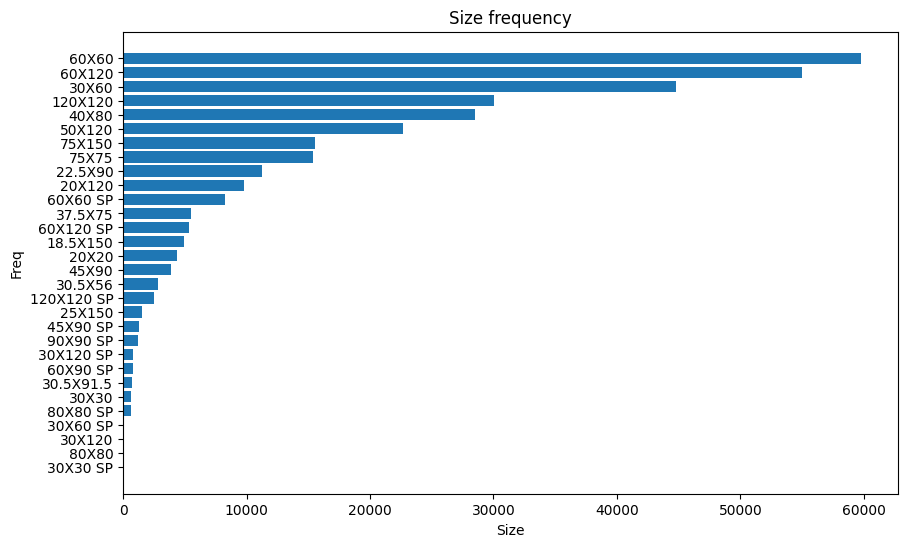

In [39]:
size_freq = {}

for sz in item_sizes:
    if sz not in current_sizes:
        continue
    size_freq[sz] = int((train_input[sz] > 0).sum())

plot_feat_group(size_freq, 'Size', 'Freq', 'Size frequency')

In [41]:
import matplotlib.pyplot as plt

def plot_two_feat(features, feat_names):

    # Sort the keys and values by the first feat
    sorted_items = sorted(features.items(), key=lambda item: item[1][0])
    sorted_keys = [item[0] for item in sorted_items]
    sorted_feat = [
        np.array([item[1][0] for item in sorted_items]),
        np.array([item[1][1] for item in sorted_items])
    ]

    # Normalize values
    norm_feat = [
        sorted_feat[0] / np.max(sorted_feat[0]),
        sorted_feat[1] / np.max(sorted_feat[1])
    ]

    df = pd.DataFrame({feat_names[1]: norm_feat[1], feat_names[0]: norm_feat[0]}, index=sorted_keys)
    res = df.plot.barh(figsize=(12, 10), title=f"{feat_names[0]} vs {feat_names[1]} (normalized)").get_figure()
    # res.savefig('mse-vs-freq.png', bbox_inches='tight')

# size_freq_weight = {}

# for sz in item_sizes:

#     if sz not in current_sizes:
#         continue
    
#     weight = size_feat.get(sz, 0)
#     freq = size_freq.get(sz, 0)
#     size_freq_weight[sz] = (weight, freq)

# plot_two_feat(size_freq_weight, feat_names=["Feature weight", "Frequency"])

In [42]:
y_predict = model.predict(X_test)
y_predict = np.round(y_predict).astype(int)

diff_df = pd.DataFrame({
    'y_test_std': y_test[:, 0],
    'y_test_big': y_test[:, 1],
    'y_predict_std': y_predict[:, 0],
    'y_predict_big': y_predict[:, 1],
    'difference_std': (y_test - y_predict)[:, 0],
    'difference_big': (y_test - y_predict)[:, 1],
    'abs_difference_std': abs(y_test - y_predict)[:, 0],
    'abs_difference_big': abs(y_test - y_predict)[:, 1],
    'abs_difference': abs(y_test - y_predict)[:,0] + abs(y_test - y_predict)[:,1]
})

df_sorted = diff_df.sort_values(by='abs_difference', ascending=False).reset_index()
df_sorted

,index,y_test_std,y_test_big,y_predict_std,y_predict_big,difference_std,difference_big,abs_difference_std,abs_difference_big,abs_difference
0,1325,15.0,2.0,33,1,-18.0,1.0,18.0,1.0,19.0
1,2547,3.0,0.0,22,0,-19.0,0.0,19.0,0.0,19.0
2,5020,21.0,0.0,4,0,17.0,0.0,17.0,0.0,17.0
3,2339,32.0,1.0,21,5,11.0,-4.0,11.0,4.0,15.0
4,4194,28.0,3.0,16,1,12.0,2.0,12.0,2.0,14.0
...,...,...,...,...,...,...,...,...,...,...
15232,22,2.0,0.0,2,0,0.0,0.0,0.0,0.0,0.0
15233,23,2.0,0.0,2,0,0.0,0.0,0.0,0.0,0.0
15234,25,2.0,3.0,2,3,0.0,0.0,0.0,0.0,0.0
15235,14,4.0,1.0,4,1,0.0,0.0,0.0,0.0,0.0


In [43]:
indexes = df_sorted.head(10)['index'].to_numpy()

bad_cases = test_input.iloc[indexes]
bad_cases

,homogeneous_order,full_order,30X30,20X20,30X60,60X60,22.5X90,60X120,45X90,75X75,30.5X56,30.5X91.5,60X60 SP,40X80,30X60 SP,45X90 SP,75X150,25X150,30X120 SP,120X120,60X120 SP,30X30 SP,18.5X150,120X120 SP,37.5X75,90X90 SP,20X120,60X90 SP,50X120,80X80 SP,30X120,80X80,pieces,weight,volume,HS2,weight_avg,volume_avg,HS1,pallets_used_std,pallets_used_big,HS3
OBD0000842924,0,0,0.0,0.0,0.0,3699.0,0.0,58.0,0.0,0.0,0.0,0.0,54.0,0.0,0.0,0.0,0.0,0.0,0.0,22.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3833.0,26610.17,1.179036e+10,36.0,6.942387,3.076014e+06,21.0,15.0,2.0,25
OBD0000319217,0,0,0.0,27420.0,0.0,0.0,600.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,28020.0,24904.60,1.120770e+10,20.0,0.888815,3.999893e+05,20.0,3.0,0.0,26
OBD0000365145,0,0,0.0,0.0,576.0,256.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,832.0,3536.00,1.566720e+09,4.0,4.250000,1.883077e+06,3.0,21.0,0.0,4
OBD0000471413,0,0,0.0,0.0,0.0,360.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,28.0,0.0,0.0,0.0,0.0,0.0,521.0,0.0,0.0,0.0,0.0,0.0,0.0,909.0,22949.20,9.969480e+09,33.0,25.246645,1.096752e+07,18.0,32.0,1.0,19
OBD0000835115,0,0,0.0,0.0,464.0,672.0,0.0,354.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,24.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1514.0,12234.42,5.398560e+09,30.0,8.080859,3.565760e+06,10.0,28.0,3.0,12
OBD0000663899,0,0,0.0,0.0,24.0,2887.0,0.0,6.0,0.0,128.0,0.0,0.0,68.0,0.0,0.0,0.0,4.0,333.0,0.0,38.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3488.0,25458.14,1.118246e+10,37.0,7.298779,3.205979e+06,20.0,18.0,7.0,25
OBD0000851574,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,360.0,0.0,0.0,0.0,0.0,300.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,660.0,26238.00,1.123200e+10,22.0,39.754545,1.701818e+07,21.0,5.0,15.0,21
OBD0000755566,0,0,0.0,150.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,700.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,850.0,23464.50,1.013400e+10,21.0,27.605294,1.192235e+07,19.0,1.0,0.0,19
OBD0000482907,0,0,0.0,0.0,0.0,480.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2691.0,0.0,0.0,0.0,3171.0,28512.80,1.527930e+10,30.0,8.991738,4.818448e+06,22.0,4.0,26.0,23
OBD0000691555,0,0,0.0,0.0,1874.0,576.0,0.0,302.0,0.0,0.0,0.0,0.0,68.0,48.0,0.0,0.0,0.0,156.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3024.0,17380.34,7.699980e+09,41.0,5.747467,2.546290e+06,14.0,39.0,2.0,18


In [44]:
def count_tile_types(row):
    cnt = 0
    for size in item_sizes:
        if size not in current_sizes:
            continue
        if row[size] > 0:
            cnt += 1
    return cnt

bad_cases_num_tiles = bad_cases.apply(count_tile_types, axis=1)
bad_cases_num_tiles

OBD0000842924    4
OBD0000319217    2
OBD0000365145    2
OBD0000471413    3
OBD0000835115    4
OBD0000663899    8
OBD0000851574    2
OBD0000755566    2
OBD0000482907    2
OBD0000691555    6
dtype: int64

In [45]:
num_tiles = np.array(test_input.apply(count_tile_types, axis=1))
# diff = diff_df['difference'].to_numpy()
abs_diff = diff_df['abs_difference'].to_numpy()

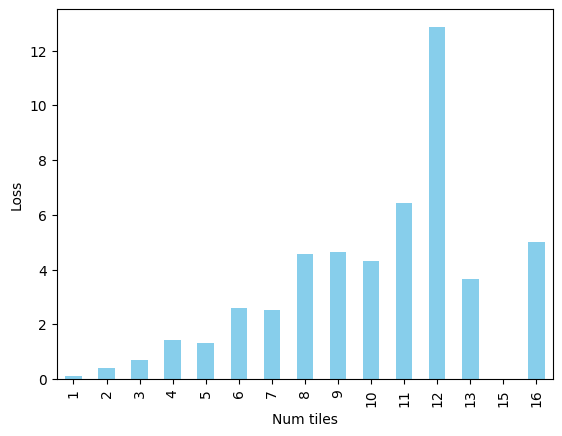

In [46]:
from sklearn.metrics import mean_squared_error

num_tiles_diff_df = pd.DataFrame({
    'y_test_0': y_test[:, 0],
    'y_test_1': y_test[:, 1],
    'y_pred_0': y_predict[:, 0],
    'y_pred_1': y_predict[:, 1],
    'num_tiles': num_tiles
})
# num_tiles_diff_df

loss_by_tiles = num_tiles_diff_df.groupby('num_tiles').apply(
    lambda g: mean_squared_error(g[['y_test_0', 'y_test_1']], g[['y_pred_0', 'y_pred_1']]),
    include_groups=False
)

loss_by_tiles.plot(kind='bar', color='skyblue')

# Add labels and title
plt.xlabel('Num tiles')
plt.ylabel('Loss')

plt.show()

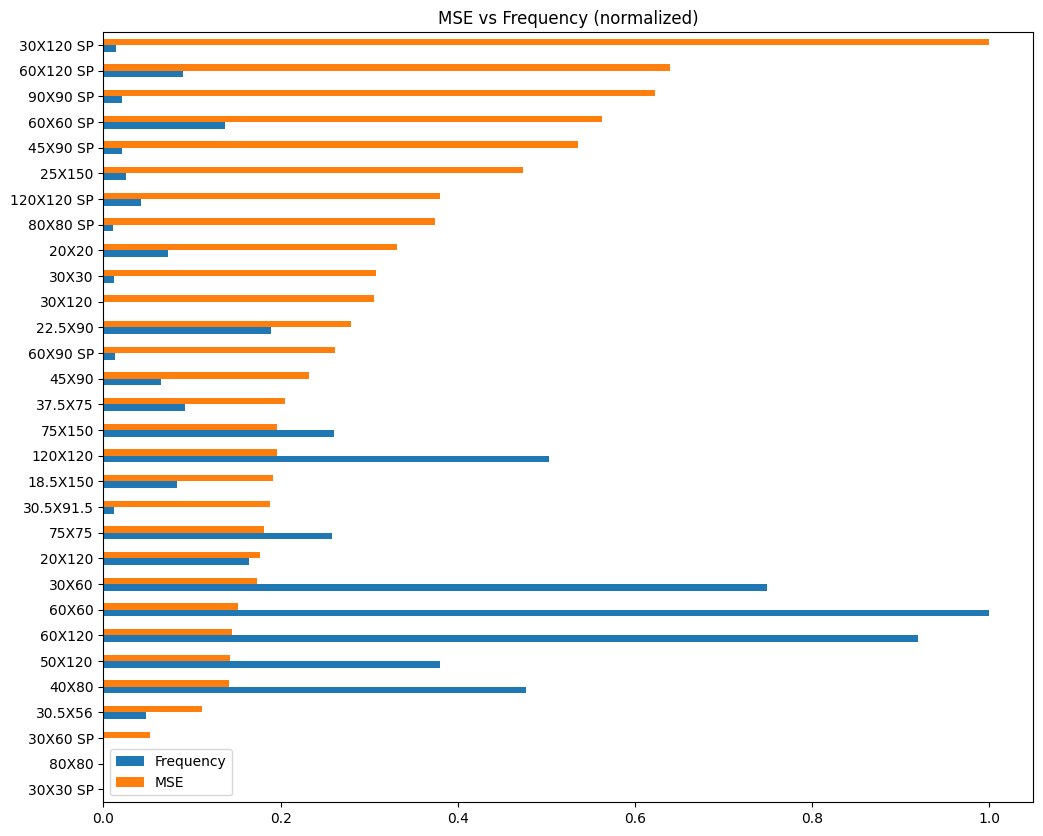

In [47]:
from sklearn.metrics import mean_squared_error

test_input_pred = test_input.copy()
test_input_pred['predict_0'] = y_predict[:,0]
test_input_pred['predict_1'] = y_predict[:,1]

loss_by_size = {}

for sz in item_sizes:
    if sz not in current_sizes:
        continue
    test_input_size = test_input_pred[test_input_pred[sz] > 0]
    if len(test_input_size) > 0:
        loss_by_size[sz] = mean_squared_error(
            [test_input_size['pallets_used_std'], test_input_size['pallets_used_big']],
            [test_input_size['predict_0'], test_input_size['predict_1']]
         )

size_freq_loss = {}

for sz in item_sizes:

    if sz not in current_sizes:
        continue
    
    loss = loss_by_size.get(sz, 0)
    freq = size_freq.get(sz, 0)
    size_freq_loss[sz] = (loss, freq)

plot_two_feat(size_freq_loss, feat_names=["MSE", "Frequency"])

In [48]:
def std_to_big_pallet_ratio(df):
    ratio_data = [[
        df[df['pallets_used_std'] > 0].shape[0], 
        df[df['pallets_used_big'] > 0].shape[0],
        df[(df['pallets_used_std'] > 0) & (df['pallets_used_big'] > 0)].shape[0],
        df.shape[0]
    ]]
    ratio_data[0].append(ratio_data[0][0] / ratio_data[0][3])
    ratio_data[0].append(ratio_data[0][1] / ratio_data[0][3])
    ratio_data[0].append(ratio_data[0][2] / ratio_data[0][3])
    return pd.DataFrame(ratio_data, columns=['std', 'big', 'both', 'total', 'std_ratio', 'big_ratio', 'both_ratio'])

In [49]:
std_to_big_pallet_ratio(train_input)

,std,big,both,total,std_ratio,big_ratio,both_ratio
0,216557,51311,18497,249371,0.868413,0.205762,0.074175


In [50]:
std_to_big_pallet_ratio(test_input)

,std,big,both,total,std_ratio,big_ratio,both_ratio
0,14276,5243,4282,15237,0.93693,0.344097,0.281026
